In [2]:
#Import libraries needed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
import sklearn.model_selection
import warnings
warnings.filterwarnings("ignore")
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sklearn.metrics import mean_squared_error
import boto3
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

In [3]:
# Set up the environment in SageMaker
session = sagemaker.Session()
role = get_execution_role()

In [15]:
#Pulling our updated data in
s3_client = boto3.client("s3")
BUCKET='ecinema'
KEY='movieedit/movieedit.csv'

response = s3_client.get_object(Bucket=BUCKET, Key=KEY)
ME = pd.read_csv(response.get("Body"))
ME.head(2)

,MovieName,Avg_GrossW,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Runtime_Value,Rated
0,'71,127085,83,32,2,0,7.5,119,2,6,99,7
1,10 Cloverfield Lane,6006917,76,38,3,2,7.7,796,3,2,104,7


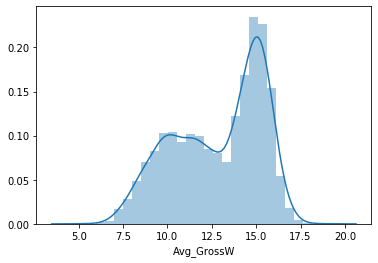

In [16]:
log_ = np.log(ME['Avg_GrossW'])
log_.skew()
sns.distplot(log_)

In [17]:
#Splitting X and Y
X = ME.drop(['MovieName','Avg_GrossW'], axis=1)
Y = pd.DataFrame(log_)

# Look at the top 5 observations
X.head()

,Metascore,Meta_Pos_Count,Meta_Neut_Count,Meta_Neg_Count,User_Score,User_Pos_Count,User_Neut_Count,User_Neg_Count,Runtime_Value,Rated
0,83,32,2,0,7.5,119,2,6,99,7
1,76,38,3,2,7.7,796,3,2,104,7
2,54,9,8,3,5.6,4,1,3,82,3
3,61,7,11,0,6.1,2,2,1,100,3
4,34,4,8,17,4.7,50,18,57,109,2


In [18]:
# Look at the top 5 observations
Y.head()

,Avg_GrossW
0,11.752611
1,15.608422
2,10.231495
3,10.836498
4,15.659063


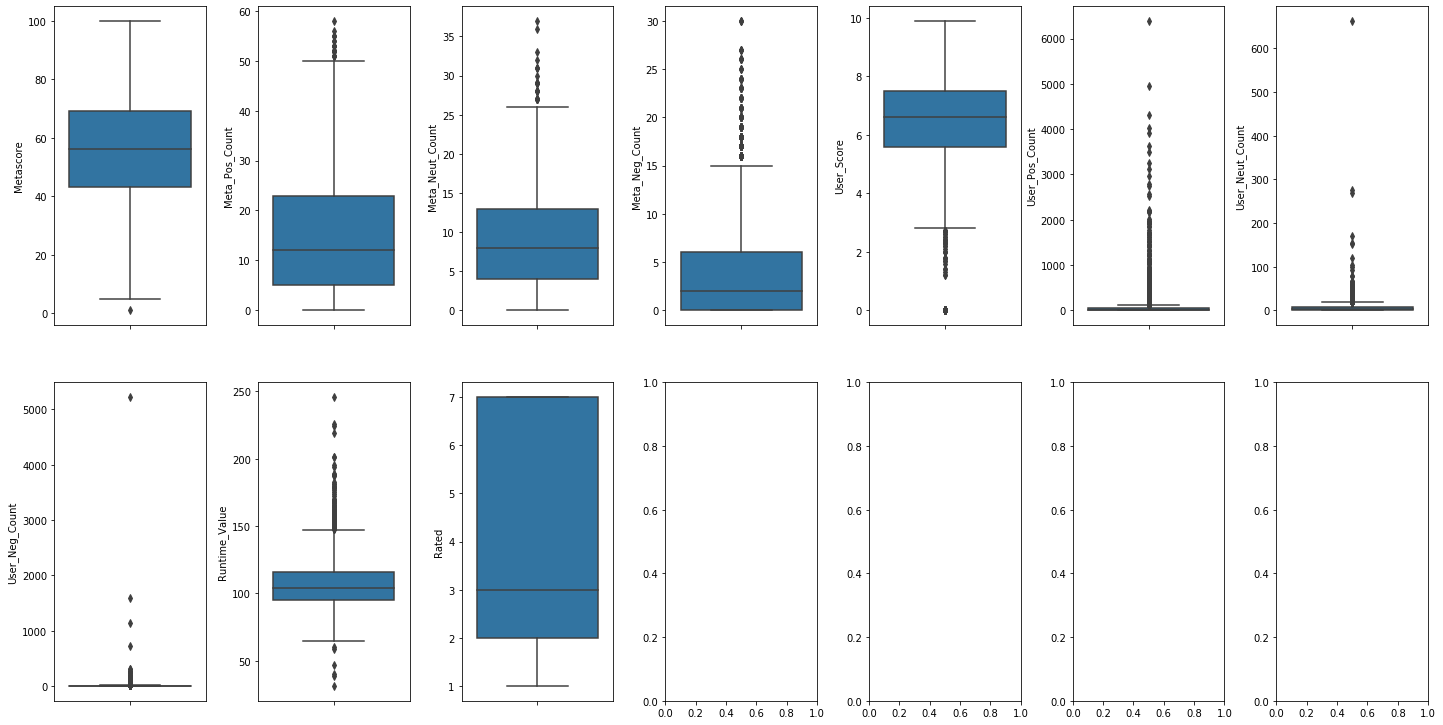

In [19]:
# Explore the distribution of our features
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in X.items():
    sns.boxplot(y=k, data=X, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

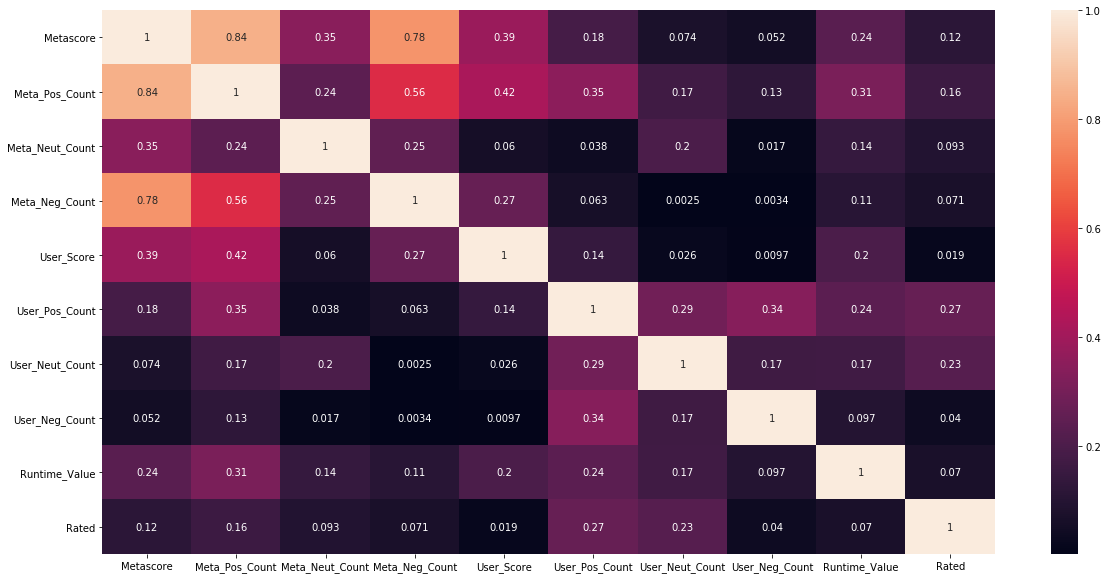

In [20]:
# Measure the correlations between features
plt.figure(figsize=(20, 10))
sns.heatmap(X.corr().abs(),  annot=True)

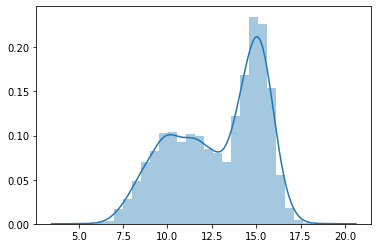

In [21]:
# Let's see the distribution of the response variable (house price)
sns.distplot(Y)

In [22]:
# Split data into train, validation and test sets
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.1)
X_test, X_val, Y_test, Y_val = sklearn.model_selection.train_test_split(X_test, Y_test, test_size=0.5)

In [23]:
#Storing files into an s3 bucket
file_name = "X_train.csv" 
X_train.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/X_train.csv')

In [24]:
#Prepping bucket to store files
file_name = "Y_train.csv" 
Y_train.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/Y_train.csv')

In [25]:
#Storing files into an s3 bucket
file_name = "test.csv" 
X_test.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/test.csv')

In [26]:
#Prepping bucket to store files
file_name = "Y_test.csv" 
Y_test.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/Y_test.csv')

In [27]:
#Storing files into an s3 bucket
file_name = "X_val.csv" 
X_val.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/X_val.csv')

In [28]:
#Prepping bucket to store files
file_name = "Y_val.csv" 
Y_val.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/Y_val.csv')

In [29]:
#Prepping bucket to store files
val = pd.concat([Y_val, X_val], axis=1)

file_name = "val.csv" 
val.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/validation/val.csv')

In [30]:
#Prepping bucket to store files
train = pd.concat([Y_train, X_train], axis=1)

file_name = "train.csv" 
train.to_csv(file_name)

import boto3
s3 = boto3.resource('s3')
s3.meta.client.upload_file(file_name, 'ecinema', 'training/train/train.csv')

In [31]:
#Prepping bucket to store files
# test = pd.concat([Y_test, X_test], axis=1)

# file_name = "test.csv" 
# test.to_csv(file_name)

# import boto3
# s3 = boto3.resource('s3')
# s3.meta.client.upload_file(file_name, 'ecinema', 'training/test/test.csv')

In [32]:
import sagemaker
import boto3
from sagemaker import image_uris
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput

In [34]:
#Create container
region = boto3.Session().region_name
container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-2")
bucket = 'ecinema'
prefix = 'training'

hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.8",
        "objective":"reg:linear",
        "num_round":"50"}

output_path = 's3://{}/{}/{}/output'.format(bucket, prefix, 'training')

xgb = sagemaker.estimator.Estimator(image_uri=container,
                                    hyperparameters=hyperparameters,
                                    role=role,
                                    instance_count=1, 
                                    instance_type='ml.m5.large', 
                                    volume_size=5, # 5 GB 
                                    output_path='s3://{}/output'.format(session.default_bucket()))

In [35]:
# Feed the train and validation sets to the model and start training
#train_channel = sagemaker.s3_input(s3_data='training/train.csv', content_type='csv')
bucket='ecinema'
prefix='training'
train_channel = TrainingInput("s3://{}/{}/{}".format(bucket, prefix, 'train.csv'), content_type='csv')
valid_channel = TrainingInput("s3://{}/{}/{}".format(bucket, prefix, 'val.csv'), content_type='csv')
# valid_channel = sagemaker.s3_input(s3_data=val_location, content_type='csv')

# data_channels = {'train': train_channel, 'validation': valid_channel}
# xgb.fit(inputs=data_channels,  logs=True)
xgb.fit({'train': train_channel, 'validation': valid_channel})

2022-04-05 02:28:08 Starting - Starting the training job...
2022-04-05 02:28:34 Starting - Preparing the instances for trainingProfilerReport-1649125688: InProgress
.........
2022-04-05 02:29:54 Downloading - Downloading input data...
2022-04-05 02:30:34 Training - Downloading the training image......
2022-04-05 02:31:36 Training - Training image download completed. Training in progress..[2022-04-05 02:31:40.059 ip-10-2-112-218.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-05:02:31:40:INFO] Imported framework sagemaker_xgboost_container.training
[2022-04-05:02:31:40:INFO] Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
[2022-04-05:02:31:40:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-05:02:31:40:INFO] Running XGBoost Sagemaker in algorithm mode
[2022-04-05:02:31:40:INFO] Determined delimiter of CSV input is ','
[2022-04-05:02:31:40:INFO] Determined delimiter of CSV input is ','
[2022-04-05:02

In [37]:
# Deploy Model
test_location = "s3://{}/{}/{}".format(bucket, prefix, 'test.csv')
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m5.large', output_path = test_location)
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

...............................[2022-04-05:02:46:35:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-05:02:46:35:INFO] No GPUs detected (normal if no gpus installed)
[2022-04-05:02:46:35:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-04-05 02:46:35 +0000] [16] [INFO] Starting guni

In [38]:
data_dir = '../ecinema/training/'
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://ecinema/training/test.csv/test.csv.out to ../ecinema/training/test.csv.out
